# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from scipy.stats import norm
import sys
import pandas as pd
import pickle
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.multitest as smt

## Helper Functions

In [2]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import covariance as c
import visualization as viz

# Set Directory Paths

In [3]:
# Directory path to load formatted gfap_ferritin_dataDir Data
%store -r gfap_ferritin_dataDir

# Directory path to save Calcualted Analysis Data
%store -r gfap_ferritin_CalData

# Load Formatted TAU, TDP43 - GFAP, Ferritin Data

In [4]:
# GFAP_TAU
with open(os.path.join(gfap_ferritin_dataDir, 'GFAP_TAU.pkl'), 'rb') as f:
    GFAP_TAU = pickle.load(f)
f.close()

# Ferr_TAU
with open(os.path.join(gfap_ferritin_dataDir, 'Ferr_TAU.pkl'), 'rb') as f:
    Ferr_TAU = pickle.load(f)
f.close()

# GFAP_TDP
with open(os.path.join(gfap_ferritin_dataDir, 'GFAP_TDP.pkl'), 'rb') as f:
    GFAP_TDP = pickle.load(f)
f.close()

# Ferr_TDP
with open(os.path.join(gfap_ferritin_dataDir, 'Ferr_TDP.pkl'), 'rb') as f:
    Ferr_TDP = pickle.load(f)
f.close()

# PATH_TAU
with open(os.path.join(gfap_ferritin_dataDir, 'PATH_TAU.pkl'), 'rb') as f:
    PATH_TAU = pickle.load(f)
f.close()

# PATH_TDP
with open(os.path.join(gfap_ferritin_dataDir, 'PATH_TDP.pkl'), 'rb') as f:
    PATH_TDP = pickle.load(f)
f.close()

In [5]:
# Load Label Names
# LabelNames
with open(os.path.join(gfap_ferritin_dataDir, 'LabelNames.pkl'), 'rb') as f:
    LabelNames = pickle.load(f)
f.close()

# Data Distribution

In [6]:
def dist_boxplot(data, labels, min_val, max_val, title, x_label, y_label):
    # Reorder the data and labels (group by regions L, R)
    new_order = [i//2 if i % 2 == 0 else (i//2) + 20 for i in range(40)]
    reordered_data = data[:, new_order]
    reordered_labels = [labels[i] for i in new_order]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create boxplots for each column
    boxplot = sns.boxplot(data=reordered_data, width=0.5, ax=ax, fliersize=0, boxprops=dict(alpha=.3))

    # Add individual data points with aligned x-values
    for i, col_data in enumerate(reordered_data.T):
        # Handle NaNs
        col_data = col_data[~np.isnan(col_data)]

        jitter = np.random.normal(0, 0.1, size=len(col_data))  # Add jitter for better visualization
        x = np.full_like(col_data, i) + jitter
        ax.scatter(x, col_data, alpha=0.5, color='blue', s=5)

     # Add vertical lines every two columns
    for i in range(1, 38, 2):
        ax.axvline(x=i + 0.5, color='grey', linestyle='--', lw=0.5)
        
    # Set x-axis labels
    ax.set_xticks(np.arange(0, 40))
    ax.set_xticklabels(reordered_labels, rotation=45, ha='right')  # Use NeuN_Labels as x-axis labels

    # Set y-axis limits (replace these values with your desired limits)
    y_min_limit = min_val  # Minimum limit
    y_max_limit = max_val  # Maximum limit
    ax.set_ylim(y_min_limit, y_max_limit)

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [7]:
# min max
all_values = np.concatenate([GFAP_TAU.flatten(), Ferr_TAU.flatten(), GFAP_TDP.flatten(), Ferr_TDP.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

## TAU - GFAP

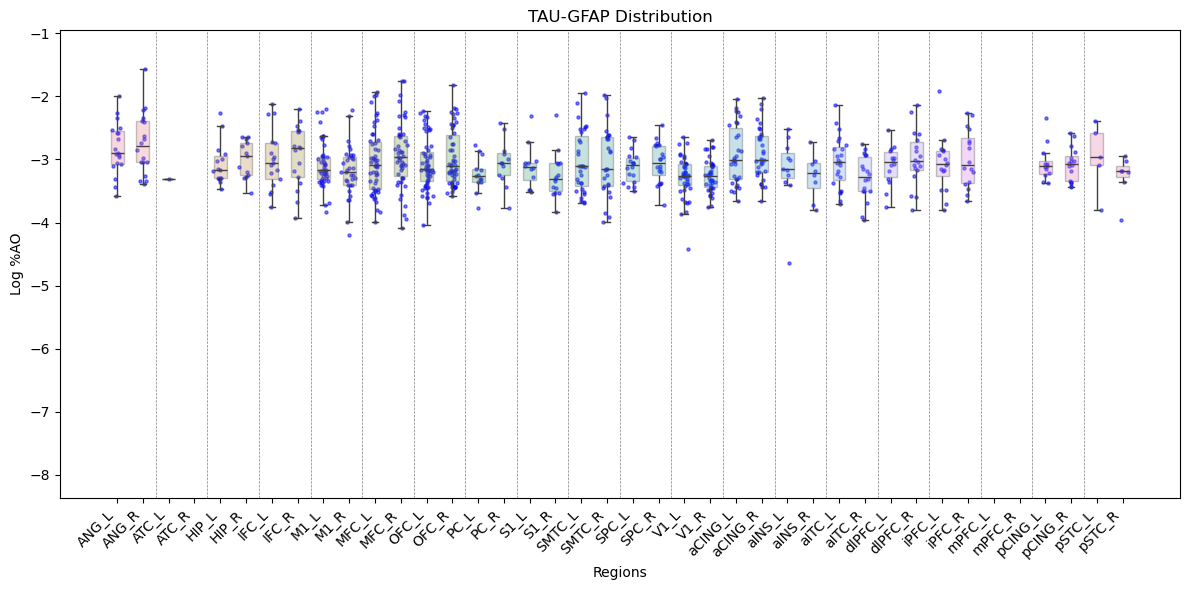

In [8]:
dist_boxplot(GFAP_TAU, LabelNames, min_val, max_val, 'TAU-GFAP Distribution', 'Regions', 'Log %AO')

## TAU - Ferritin

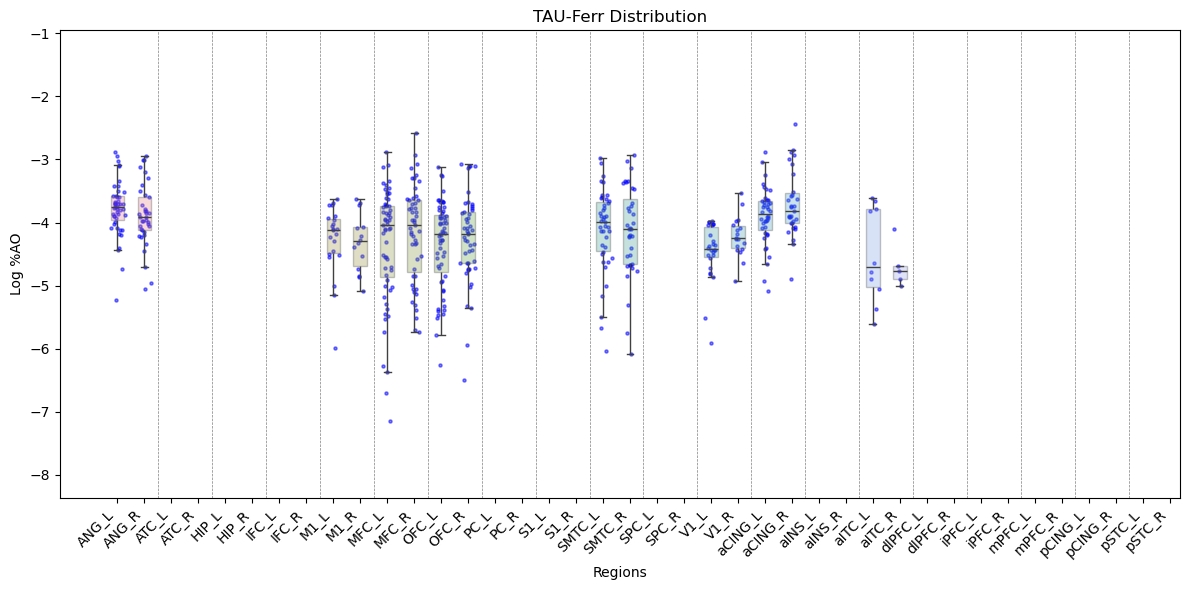

In [9]:
dist_boxplot(Ferr_TAU, LabelNames, min_val, max_val, 'TAU-Ferr Distribution', 'Regions', 'Log %AO')

## TDP - GFAP

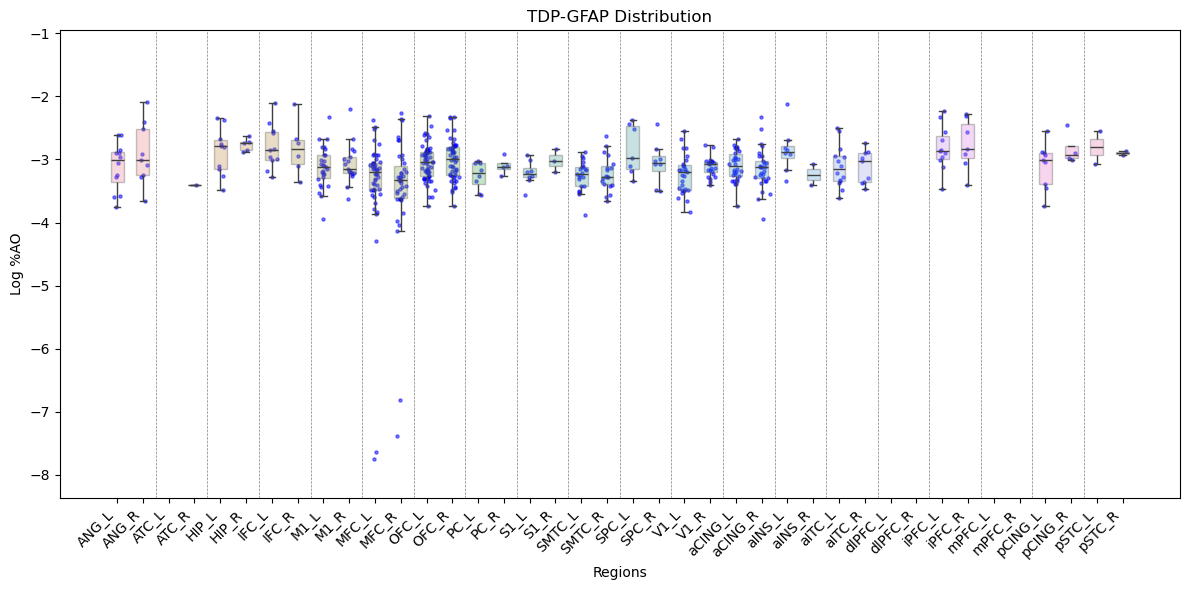

In [10]:
dist_boxplot(GFAP_TDP, LabelNames, min_val, max_val, 'TDP-GFAP Distribution', 'Regions', 'Log %AO')

## TDP - Ferritin

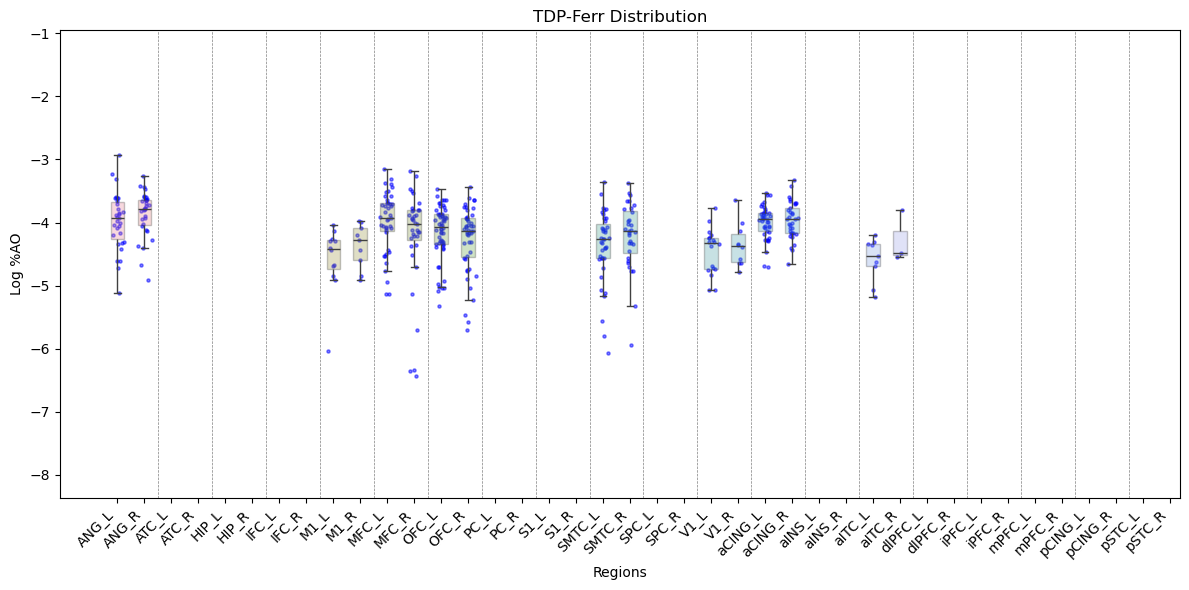

In [11]:
dist_boxplot(Ferr_TDP, LabelNames, min_val, max_val, 'TDP-Ferr Distribution', 'Regions', 'Log %AO')

## TAU - Pathology

In [12]:
# min max
all_values = np.concatenate([PATH_TAU.flatten(), PATH_TDP.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

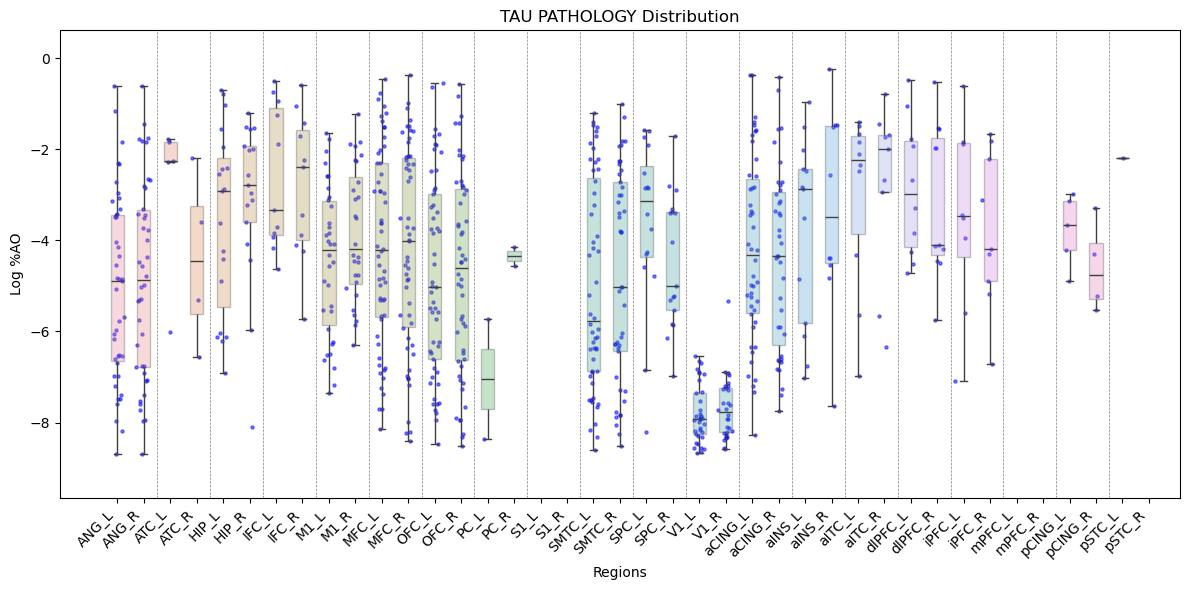

In [13]:
dist_boxplot(PATH_TAU, LabelNames, min_val, max_val, 'TAU PATHOLOGY Distribution', 'Regions', 'Log %AO')

## TDP - Pathology

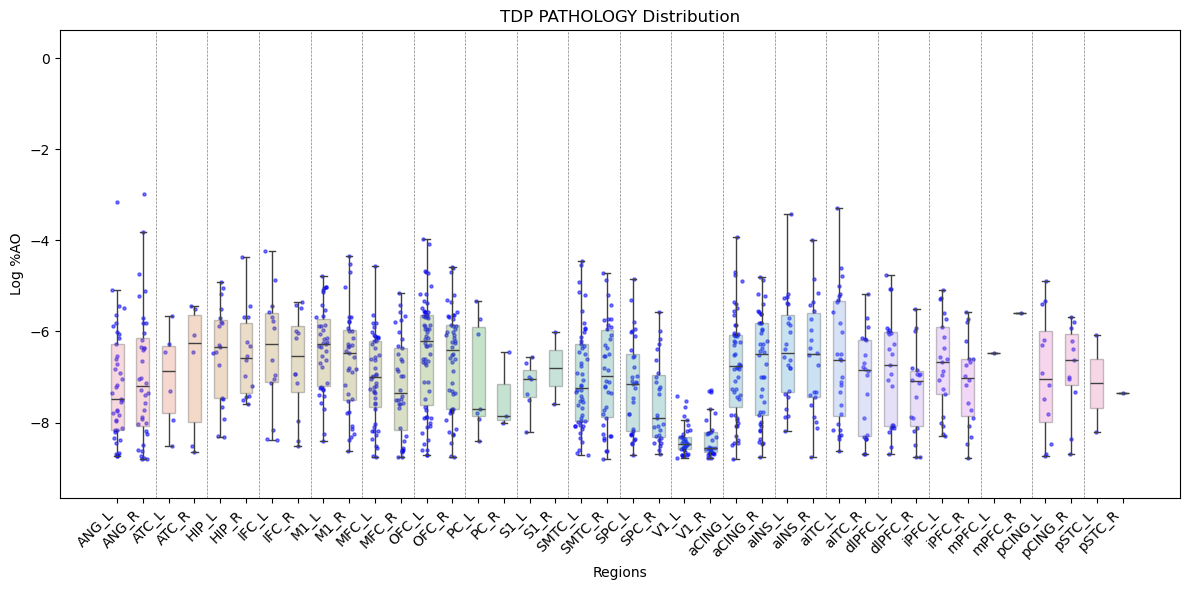

In [14]:
dist_boxplot(PATH_TDP, LabelNames, min_val, max_val, 'TDP PATHOLOGY Distribution', 'Regions', 'Log %AO')

# T-test between TAU vs TDP

In [15]:
def t_test_func(left_data, right_data, LabelNames):
    # Perform t-test for each column
    p_values = [stats.ttest_ind(left_data[:, i], right_data[:, i], equal_var=False, nan_policy='omit', alternative='two-sided').pvalue for i in range(left_data.shape[1])]

    # Identifying indices with NaN p-values
    nan_indices = [i for i, p in enumerate(p_values) if p is None or np.isnan(p)]
    valid_indices = [i for i in range(len(p_values)) if i not in nan_indices]
    valid_p_values = [p_values[i] for i in valid_indices]

    # Multiple comparison correction for non-NaN p-values
    corrected_p_values = smt.multipletests(valid_p_values, method='fdr_bh')[1]

    # Initialize a new array with NaNs and replace non-NaN positions with corrected p-values
    final_p_values = np.full(len(p_values), np.nan)
    for i, val in zip(valid_indices, corrected_p_values):
        final_p_values[i] = val

    # Region names for output
    region_names = LabelNames

    # Output the corrected p-values
    for i, p_val in enumerate(final_p_values):
        if np.isnan(p_val):
            print(f"{region_names[i]:<10}: p-value cannot be computed")
        else:
            difference_status = "NOT significantly different" if p_val > 0.05 else "significantly different"
            print(f"{region_names[i]:<10}: Corrected p-value = {p_val:.4f} / {difference_status}")



## GFAP: TAU vs TDP

In [16]:
print("T-Test for GFAP: TAU vs TDP")
t_test_func(GFAP_TAU, GFAP_TDP, LabelNames)

T-Test for GFAP: TAU vs TDP
ANG_L     : Corrected p-value = 0.2304 / NOT significantly different
ATC_L     : p-value cannot be computed
HIP_L     : Corrected p-value = 0.3780 / NOT significantly different
IFC_L     : Corrected p-value = 0.3780 / NOT significantly different
M1_L      : Corrected p-value = 0.7797 / NOT significantly different
MFC_L     : Corrected p-value = 0.1593 / NOT significantly different
OFC_L     : Corrected p-value = 0.8405 / NOT significantly different
PC_L      : Corrected p-value = 0.8736 / NOT significantly different
S1_L      : Corrected p-value = 0.6307 / NOT significantly different
SMTC_L    : Corrected p-value = 0.1712 / NOT significantly different
SPC_L     : Corrected p-value = 0.3436 / NOT significantly different
V1_L      : Corrected p-value = 0.7451 / NOT significantly different
aCING_L   : Corrected p-value = 0.3003 / NOT significantly different
aINS_L    : Corrected p-value = 0.3436 / NOT significantly different
aITC_L    : Corrected p-value = 0.77

In [17]:
print("T-Test for Ferritin: TAU vs TDP")
t_test_func(Ferr_TAU, Ferr_TDP, LabelNames)

T-Test for Ferritin: TAU vs TDP
ANG_L     : Corrected p-value = 0.2294 / NOT significantly different
ATC_L     : p-value cannot be computed
HIP_L     : p-value cannot be computed
IFC_L     : p-value cannot be computed
M1_L      : Corrected p-value = 0.3013 / NOT significantly different
MFC_L     : Corrected p-value = 0.1398 / NOT significantly different
OFC_L     : Corrected p-value = 0.2485 / NOT significantly different
PC_L      : p-value cannot be computed
S1_L      : p-value cannot be computed
SMTC_L    : Corrected p-value = 0.2294 / NOT significantly different
SPC_L     : p-value cannot be computed
V1_L      : Corrected p-value = 0.8990 / NOT significantly different
aCING_L   : Corrected p-value = 0.4744 / NOT significantly different
aINS_L    : p-value cannot be computed
aITC_L    : Corrected p-value = 0.8990 / NOT significantly different
dlPFC_L   : p-value cannot be computed
iPFC_L    : p-value cannot be computed
mPFC_L    : p-value cannot be computed
pCING_L   : p-value cannot

In [18]:
print("T-Test for Pathology: TAU vs TDP")
t_test_func(PATH_TAU, PATH_TDP, LabelNames)

T-Test for Pathology: TAU vs TDP
ANG_L     : Corrected p-value = 0.0000 / significantly different
ATC_L     : Corrected p-value = 0.0037 / significantly different
HIP_L     : Corrected p-value = 0.0000 / significantly different
IFC_L     : Corrected p-value = 0.0000 / significantly different
M1_L      : Corrected p-value = 0.0000 / significantly different
MFC_L     : Corrected p-value = 0.0000 / significantly different
OFC_L     : Corrected p-value = 0.0000 / significantly different
PC_L      : Corrected p-value = 0.9784 / NOT significantly different
S1_L      : p-value cannot be computed
SMTC_L    : Corrected p-value = 0.0000 / significantly different
SPC_L     : Corrected p-value = 0.0000 / significantly different
V1_L      : Corrected p-value = 0.0000 / significantly different
aCING_L   : Corrected p-value = 0.0000 / significantly different
aINS_L    : Corrected p-value = 0.0008 / significantly different
aITC_L    : Corrected p-value = 0.0002 / significantly different
dlPFC_L   : Co

/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


# Parameter/Variable Setting

## P-value Threshold List

In [19]:
# pthresh_list = [0.05]
pthresh = 0.05

## Covariance Matrix Threshold (to remove noise)

In [20]:
cov_thresh = 0.1

## LabelNames we are able to map to 3D. In alphabetical order (_L first and then _R)

In [21]:
LabelNames

Index(['ANG_L', 'ATC_L', 'HIP_L', 'IFC_L', 'M1_L', 'MFC_L', 'OFC_L', 'PC_L',
       'S1_L', 'SMTC_L', 'SPC_L', 'V1_L', 'aCING_L', 'aINS_L', 'aITC_L',
       'dlPFC_L', 'iPFC_L', 'mPFC_L', 'pCING_L', 'pSTC_L', 'ANG_R', 'ATC_R',
       'HIP_R', 'IFC_R', 'M1_R', 'MFC_R', 'OFC_R', 'PC_R', 'S1_R', 'SMTC_R',
       'SPC_R', 'V1_R', 'aCING_R', 'aINS_R', 'aITC_R', 'dlPFC_R', 'iPFC_R',
       'mPFC_R', 'pCING_R', 'pSTC_R'],
      dtype='object', name='Region')

# Calculate Covariance Matrices

## TAU - GFAP

In [22]:
covGFAP_TAU = c.covCal(GFAP_TAU, GFAP_TAU, cov_thresh)

## TAU - Ferritin

In [23]:
covFerr_TAU = c.covCal(Ferr_TAU, Ferr_TAU, cov_thresh)

## TAU - Pathology

In [24]:
cov_TAU = c.covCal(PATH_TAU, PATH_TAU, cov_thresh)

## TDP43 - GFAP

In [25]:
covGFAP_TDP = c.covCal(GFAP_TDP, GFAP_TDP, cov_thresh)

## TDP43 - Ferritin

In [26]:
covFerr_TDP = c.covCal(Ferr_TDP, Ferr_TDP, cov_thresh)

## TDP43 - Pathology

In [27]:
cov_TDP = c.covCal(PATH_TDP, PATH_TDP, cov_thresh)

## 3. TAU > TDP and TDP > TAU (GFAP, Ferritin, Pathology)

In [28]:
covGFAP_TAU_gt_TDP, covGFAP_TDP_gt_TAU = c.covCalSigXY(GFAP_TAU, GFAP_TDP, covGFAP_TAU, covGFAP_TDP, pthresh, cov_thresh)

In [29]:
covFerr_TAU_gt_TDP, covFerr_TDP_gt_TAU = c.covCalSigXY(Ferr_TAU, Ferr_TDP, covFerr_TAU, covFerr_TDP, pthresh, cov_thresh)

In [30]:
cov_TAU_gt_TDP, cov_TDP_gt_TAU = c.covCalSigXY(PATH_TAU, PATH_TDP, cov_TAU, cov_TDP, pthresh, cov_thresh)

## 4. TAU > TDP and TDP > TAU RAW

In [31]:
covGFAP_TAU_gt_TDP_raw, covGFAP_TDP_gt_TAU_raw = c.covCalSigXYRaw(GFAP_TAU, GFAP_TDP, covGFAP_TAU, covGFAP_TDP, cov_thresh)

In [32]:
covFerr_TAU_gt_TDP_raw, covFerr_TDP_gt_TAU_raw = c.covCalSigXYRaw(Ferr_TAU, Ferr_TDP, covFerr_TAU, covFerr_TDP, cov_thresh)

In [33]:
cov_TAU_gt_TDP_raw, cov_TDP_gt_TAU_raw = c.covCalSigXYRaw(PATH_TAU, PATH_TDP, cov_TAU, cov_TDP, cov_thresh)

# Saving

In [34]:
# covGFAP_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TAU.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TAU, f)
f.close()
# covFerr_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TAU.pkl'), 'wb') as f:
    pickle.dump(covFerr_TAU, f)
f.close()
#----------------------------------------------------------------------------
# covGFAP_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TDP.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TDP, f)
f.close()
# covFerr_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TDP.pkl'), 'wb') as f:
    pickle.dump(covFerr_TDP, f)
f.close()
#----------------------------------------------------------------------------
# covGFAP_TAU_gt_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TAU_gt_TDP.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TAU_gt_TDP, f)
f.close()
# covGFAP_TDP_gt_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TDP_gt_TAU.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TDP_gt_TAU, f)
f.close()
#----------------------------------------------------------------------------
# covFerr_TAU_gt_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TAU_gt_TDP.pkl'), 'wb') as f:
    pickle.dump(covFerr_TAU_gt_TDP, f)
f.close()
# covFerr_TDP_gt_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TDP_gt_TAU.pkl'), 'wb') as f:
    pickle.dump(covFerr_TDP_gt_TAU, f)
f.close()
#----------------------------------------------------------------------------
# covGFAP_TAU_gt_TDP_raw
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TAU_gt_TDP_raw.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TAU_gt_TDP_raw, f)
f.close()
# covGFAP_TDP_gt_TAU_raw
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TDP_gt_TAU_raw.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TDP_gt_TAU_raw, f)
f.close()
#----------------------------------------------------------------------------
# covFerr_TAU_gt_TDP_raw
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TAU_gt_TDP_raw.pkl'), 'wb') as f:
    pickle.dump(covFerr_TAU_gt_TDP_raw, f)
f.close()
# covFerr_TDP_gt_TAU_raw
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TDP_gt_TAU_raw.pkl'), 'wb') as f:
    pickle.dump(covFerr_TDP_gt_TAU_raw, f)
f.close()

In [35]:
# cov_TAU
with open(os.path.join(gfap_ferritin_CalData, 'cov_TAU.pkl'), 'wb') as f:
    pickle.dump(cov_TAU, f)
f.close()
# cov_TDP
with open(os.path.join(gfap_ferritin_CalData, 'cov_TDP.pkl'), 'wb') as f:
    pickle.dump(cov_TDP, f)
f.close()
#----------------------------------------------------------------------------
# cov_TAU_gt_TDP
with open(os.path.join(gfap_ferritin_CalData, 'cov_TAU_gt_TDP.pkl'), 'wb') as f:
    pickle.dump(cov_TAU_gt_TDP, f)
f.close()
# cov_TDP_gt_TAU
with open(os.path.join(gfap_ferritin_CalData, 'cov_TDP_gt_TAU.pkl'), 'wb') as f:
    pickle.dump(cov_TDP_gt_TAU, f)
f.close()
#----------------------------------------------------------------------------
# cov_TAU_gt_TDP_raw
with open(os.path.join(gfap_ferritin_CalData, 'cov_TAU_gt_TDP_raw.pkl'), 'wb') as f:
    pickle.dump(cov_TAU_gt_TDP_raw, f)
f.close()
# cov_TDP_gt_TAU_raw
with open(os.path.join(gfap_ferritin_CalData, 'cov_TDP_gt_TAU_raw.pkl'), 'wb') as f:
    pickle.dump(cov_TDP_gt_TAU_raw, f)
f.close()

In [36]:
print(np.count_nonzero(~np.isnan(covGFAP_TAU_gt_TDP_raw))/2)
print(np.count_nonzero(~np.isnan(covGFAP_TDP_gt_TAU_raw))/2)

113.0
113.0


In [37]:
print(np.count_nonzero(~np.isnan(covFerr_TAU_gt_TDP_raw))/2)
print(np.count_nonzero(~np.isnan(covFerr_TDP_gt_TAU_raw))/2)

36.0
36.0
